In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import os

In [ ]:
# Resolve project root dynamically based on current working directory
project_root = Path.cwd()
data_root = project_root / "data"
train_dir = data_root / "train"
valid_dir = data_root / "valid"

In [ ]:
# Use local dataset only (no Kaggle download)
print("Using local dataset at:", data_root)
print("Train dir:", train_dir)
print("Valid dir:", valid_dir)


In [ ]:
# Ensure dataset directories exist and are populated
train_dir.mkdir(parents=True, exist_ok=True)
valid_dir.mkdir(parents=True, exist_ok=True)

# Quick sanity checks and helpful error if empty
def dir_has_images_by_class(root: Path) -> bool:
    try:
        subdirs = [p for p in root.iterdir() if p.is_dir()]
    except FileNotFoundError:
        return False
    if not subdirs:
        return False
    for sd in subdirs:
        for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.gif"):
            if any(sd.glob(ext)):
                return True
    return False

if not dir_has_images_by_class(train_dir) or not dir_has_images_by_class(valid_dir):
    raise FileNotFoundError(
        f"Dataset not found. Expected structure:\n"
        f"{data_root}\n"
        f"  ├─ train/\n"
        f"  │   ├─ class_1/ image files...\n"
        f"  │   └─ class_2/ ...\n"
        f"  └─ valid/\n"
        f"      ├─ class_1/ image files...\n"
        f"      └─ class_2/ ...\n\n"
        f"Current train exists: {train_dir.exists()}, valid exists: {valid_dir.exists()}\n"
        f"Tip: Copy your dataset into these folders."
    )


In [ ]:
# Optimized dataset loading 
training_set_raw = tf.keras.utils.image_dataset_from_directory(
    str(train_dir),
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=128,  
    image_size=(128, 128),
    shuffle=True,
)

# Store class names BEFORE applying transformations
class_names = training_set_raw.class_names
num_classes = len(class_names)

# Add optimizations: normalize with parallel processing
training_set = training_set_raw.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Aggressive prefetching for maximum GPU utilization
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Loaded {num_classes} classes: {class_names}")
print(f"Batch size: 128 (optimized for speed)")
print(f"⚠️ Disk cache removed - first epoch will be faster (~40 mins expected)")

In [ ]:
# This cell provides a summary of the dataset
print("\n=== Dataset Summary ===")
print(f"Number of classes: {num_classes}")
print(f"\nClass names:")
for i, name in enumerate(class_names, 1):
    print(f"  {i}. {name}")


#CNN ARCHITECTURE

In [ ]:
cnn = tf.keras.models.Sequential()

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [ ]:
cnn.add(tf.keras.layers.Dropout(0.25))

In [ ]:
cnn.add(tf.keras.layers.Flatten())

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))

In [ ]:
cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting

In [ ]:
#Output Layer
cnn.add(tf.keras.layers.Dense(units=num_classes,activation='softmax'))

In [ ]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cnn.summary()

#TRAINING THE MODEL

In [102]:
# Setup checkpoint and callbacks
models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = models_dir / "best_model.keras"

# Create callbacks for training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor='accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Try to load validation set
USE_VALIDATION = False
validation_set = None
try:
    validation_set_raw = tf.keras.utils.image_dataset_from_directory(
        str(valid_dir),
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=128,
        image_size=(128, 128),
        shuffle=True,
    )
    validation_set = validation_set_raw.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(buffer_size=tf.data.AUTOTUNE)
    USE_VALIDATION = True
except Exception as e:
    print(f"Could not load validation set: {e}")
    validation_set = None

# Calculate total steps per epoch for display
import math
batch_size = training_set_raw._batch_size if hasattr(training_set_raw, '_batch_size') else 128
if hasattr(batch_size, 'value'):
    batch_size = batch_size.value
try:
    # Count samples from dataset
    total_samples = sum(1 for _ in training_set_raw)
    total_samples *= batch_size
except:
    total_samples = 70295  # fallback
steps_per_epoch = math.ceil(total_samples / batch_size)

print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)
print(f"Training for up to 20 epochs")
print(f"Batch size: {batch_size}")
print(f"Total samples: {total_samples:,}")
print(f"Steps per epoch: ~{steps_per_epoch}")
print(f"Initial learning rate: {cnn.optimizer.learning_rate.numpy()}")
print(f"Model will be saved to: {checkpoint_path}")
if USE_VALIDATION and validation_set is not None:
    print("✓ Using validation set during training")
else:
    print("⚠ Training without validation set")
print("=" * 80 + "\n")

# Train the model with verbose progress bar
training_history = cnn.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=20,
    verbose=1,  # Shows progress bar: 1/550, 2/550, etc.
    callbacks=callbacks
)

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1837 - loss: 2.9741
Epoch 1: accuracy improved from None to 0.34847, saving model to d:\9) Projects\16) PlantPulse\models\best_model.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 2040s 4s/step - accuracy: 0.3485 - loss: 2.2877 - val_accuracy: 0.6307 - val_loss: 1.2623
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6375 - loss: 1.1803
Epoch 2: accuracy improved from 0.34847 to 0.67624, saving model to d:\9) Projects\16) PlantPulse\models\best_model.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 1680s 3s/step - accuracy: 0.6762 - loss: 1.0458 - val_accuracy: 0.7709 - val_loss: 0.7231
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7599 - loss: 0.7671
Epoch 3: accuracy improved from 0.67624 to 0.77981, saving model to d:\9) Projects\16) PlantPulse\models\best_model.keras
550/550 ━━━━━━━━━━━━━━━━━━━━ 1814s 3s/step - accuracy: 0.7798 - loss: 0.6995 - val_accuracy: 0.8481 - val_loss: 0.4784
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━

#EVALUATING THE MODEL

In [104]:
# Training accuracy is already available from training_history - no need to re-evaluate
print("Training accuracy from training history:")
if 'accuracy' in training_history.history:
    print(f"Final training accuracy: {training_history.history['accuracy'][-1]:.4f}")
else:
    print("Training history not available")

Training accuracy from training history:
Final training accuracy: 0.9823


In [ ]:
# Save the final trained model
print("=" * 80)
print("SAVING TRAINED MODEL")
print("=" * 80)

models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save the final model 
final_save_path = models_dir / "my_model_24.keras"
checkpoint_path = models_dir / "best_model.keras"

# If best model checkpoint exists, load it
if checkpoint_path.exists():
    print(f"Loading best model from checkpoint: {checkpoint_path}")
    cnn = tf.keras.models.load_model(str(checkpoint_path))
    print("Best model loaded successfully!")
    print(f"Model summary: {cnn.count_params()} parameters")
else:
    print("No checkpoint found, saving current model state")

# Save the model to the final location
cnn.save(str(final_save_path))
print(f"Model saved to: {final_save_path}")

# Also save a copy to frontend/models if it exists
frontend_models_dir = project_root / "frontend" / "models"
if frontend_models_dir.exists():
    frontend_save_path = frontend_models_dir / "my_model_24.keras"
    cnn.save(str(frontend_save_path))
    print(f"Model also saved to: {frontend_save_path}")

print("\n" + "=" * 80)
print("MODEL SAVING COMPLETED!")
print("=" * 80)

# Return training history dictionary
training_history.history

SAVING TRAINED MODEL
Loading best model from checkpoint: d:\9) Projects\16) PlantPulse\models\best_model.keras


{'accuracy': [0.34847429394721985,
  0.6762358546257019,
  0.7798136472702026,
  0.8369016051292419,
  0.8728643655776978,
  0.8963368535041809,
  0.9125400185585022,
  0.9282452464103699,
  0.9381179213523865,
  0.9479479193687439,
  0.9525428414344788,
  0.9601393938064575,
  0.9648196697235107,
  0.9685041904449463,
  0.9720321297645569,
  0.974791944026947,
  0.9772956967353821,
  0.9778647422790527,
  0.9792161583900452,
  0.9822604656219482],
 'loss': [2.2876923084259033,
  1.045804738998413,
  0.6995336413383484,
  0.5077275037765503,
  0.3921297490596771,
  0.3177652657032013,
  0.26242172718048096,
  0.215112566947937,
  0.1831778883934021,
  0.15443745255470276,
  0.1374150663614273,
  0.11757718026638031,
  0.10341770201921463,
  0.0925048217177391,
  0.08171210438013077,
  0.07481935620307922,
  0.06792926788330078,
  0.06399316340684891,
  0.05912024900317192,
  0.05183212086558342],
 'val_accuracy': [0.6307193040847778,
  0.7709423899650574,
  0.8480536937713623,
  0.8684

In [106]:
training_history.history #Return Dictionary of history

{'accuracy': [0.34847429394721985,
  0.6762358546257019,
  0.7798136472702026,
  0.8369016051292419,
  0.8728643655776978,
  0.8963368535041809,
  0.9125400185585022,
  0.9282452464103699,
  0.9381179213523865,
  0.9479479193687439,
  0.9525428414344788,
  0.9601393938064575,
  0.9648196697235107,
  0.9685041904449463,
  0.9720321297645569,
  0.974791944026947,
  0.9772956967353821,
  0.9778647422790527,
  0.9792161583900452,
  0.9822604656219482],
 'loss': [2.2876923084259033,
  1.045804738998413,
  0.6995336413383484,
  0.5077275037765503,
  0.3921297490596771,
  0.3177652657032013,
  0.26242172718048096,
  0.215112566947937,
  0.1831778883934021,
  0.15443745255470276,
  0.1374150663614273,
  0.11757718026638031,
  0.10341770201921463,
  0.0925048217177391,
  0.08171210438013077,
  0.07481935620307922,
  0.06792926788330078,
  0.06399316340684891,
  0.05912024900317192,
  0.05183212086558342],
 'val_accuracy': [0.6307193040847778,
  0.7709423899650574,
  0.8480536937713623,
  0.8684

In [107]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [108]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


#VISUALIZING ACCURACY

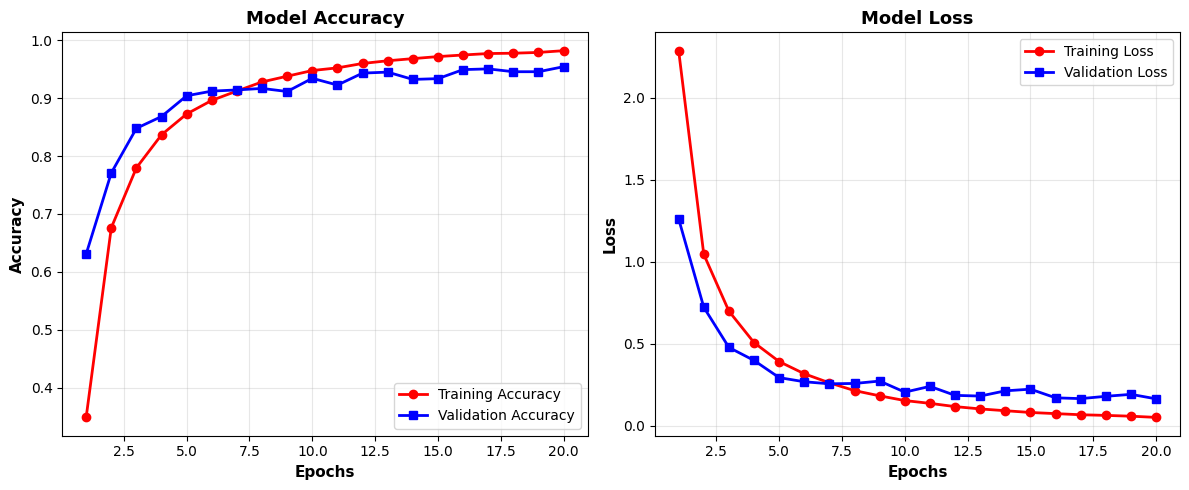

TRAINING SUMMARY
Total epochs: 20
Best validation accuracy: 0.9546 at epoch 20
Final training accuracy: 0.9823
Final validation accuracy: 0.9546


In [109]:
# Visualize Training and Validation Accuracy
epochs = range(1, len(training_history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_history.history['accuracy'], 
         color='red', marker='o', linewidth=2, markersize=6, label='Training Accuracy')
if 'val_accuracy' in training_history.history:
    plt.plot(epochs, training_history.history['val_accuracy'], 
             color='blue', marker='s', linewidth=2, markersize=6, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=11, fontweight='bold')
plt.ylabel('Accuracy', fontsize=11, fontweight='bold')
plt.title('Model Accuracy', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_history.history['loss'], 
         color='red', marker='o', linewidth=2, markersize=6, label='Training Loss')
if 'val_loss' in training_history.history:
    plt.plot(epochs, training_history.history['val_loss'], 
             color='blue', marker='s', linewidth=2, markersize=6, label='Validation Loss')
plt.xlabel('Epochs', fontsize=11, fontweight='bold')
plt.ylabel('Loss', fontsize=11, fontweight='bold')
plt.title('Model Loss', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Print summary
print("=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)
print(f"Total epochs: {len(epochs)}")
if 'val_accuracy' in training_history.history:
    print(f"Best validation accuracy: {max(training_history.history['val_accuracy']):.4f} at epoch {training_history.history['val_accuracy'].index(max(training_history.history['val_accuracy'])) + 1}")
print(f"Final training accuracy: {training_history.history['accuracy'][-1]:.4f}")
if 'val_accuracy' in training_history.history:
    print(f"Final validation accuracy: {training_history.history['val_accuracy'][-1]:.4f}")
print("=" * 80)

In [ ]:
# Create test set for evaluation (separate from training validation_set)

print("Creating test set from valid_dir...")
test_set_raw = tf.keras.utils.image_dataset_from_directory(
    str(valid_dir),
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=128,
    image_size=(128, 128),
    shuffle=False,  
)

# Normalize and optimize the test set
test_set = test_set_raw.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Test set created with {len(list(test_set_raw.file_paths))} samples" if hasattr(test_set_raw, 'file_paths') else "Test set created")

Using existing validation set from training


In [ ]:
# REPORT GENERATION CELLS START HERE

print("=" * 80)
print("LOADING BEST MODEL FOR REPORT GENERATION")
print("=" * 80)

models_dir = project_root / "models"
checkpoint_path = models_dir / "best_model.keras"

if checkpoint_path.exists():
    print(f"Loading best model from: {checkpoint_path}")
    cnn = tf.keras.models.load_model(str(checkpoint_path))
    print(f"✓ Model loaded successfully! ({cnn.count_params():,} parameters)")
else:
    print("ERROR: best_model.keras not found!")
    
print("=" * 80)

LOADING BEST MODEL FOR REPORT GENERATION
Loading best model from: d:\9) Projects\16) PlantPulse\models\best_model.keras


In [131]:
# Create test set for evaluation
print("Creating test set from valid_dir...")
test_set_raw = tf.keras.utils.image_dataset_from_directory(
    str(valid_dir),
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=128,
    image_size=(128, 128),
    shuffle=False,
)

# Normalize and optimize the test set
test_set = test_set_raw.map(
    lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"✓ Test set created successfully")


Creating test set from valid_dir...


In [132]:
# Evaluate on test set
print("=" * 80)
print("EVALUATING MODEL ON TEST SET")
print("=" * 80)
test_loss, test_acc = cnn.evaluate(test_set, verbose=1)
print("\n" + "=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("=" * 80)


EVALUATING MODEL ON TEST SET


In [133]:
# Generate predictions for confusion matrix and classification report
print("Generating predictions for confusion matrix...")
y_pred = cnn.predict(test_set, verbose=1)
predicted_categories = tf.argmax(y_pred, axis=1)

# Get true labels
true_categories_list = []
for _, labels in test_set:
    true_categories_list.append(labels.numpy())
true_categories = tf.concat(true_categories_list, axis=0)
Y_true = tf.argmax(true_categories, axis=1)

print(f"✓ Predictions generated: {len(predicted_categories)} samples")


Generating predictions for confusion matrix...


In [136]:
# Classification Report
from sklearn.metrics import confusion_matrix, classification_report

print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
class_names_list = test_set_raw.class_names  # Use test_set_raw, not test_set
print(classification_report(Y_true, predicted_categories, target_names=class_names_list))
print("=" * 80)


CLASSIFICATION REPORT
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.93      0.92      0.92       504
                                 Apple___Black_rot       0.99      0.96      0.97       497
                          Apple___Cedar_apple_rust       0.96      0.90      0.93       440
                                   Apple___healthy       0.92      0.97      0.94       502
                               Blueberry___healthy       0.92      0.97      0.95       454
          Cherry_(including_sour)___Powdery_mildew       0.95      0.98      0.96       421
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.96      0.91       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       

✓ Confusion matrix saved as 'confusion_matrix.png'


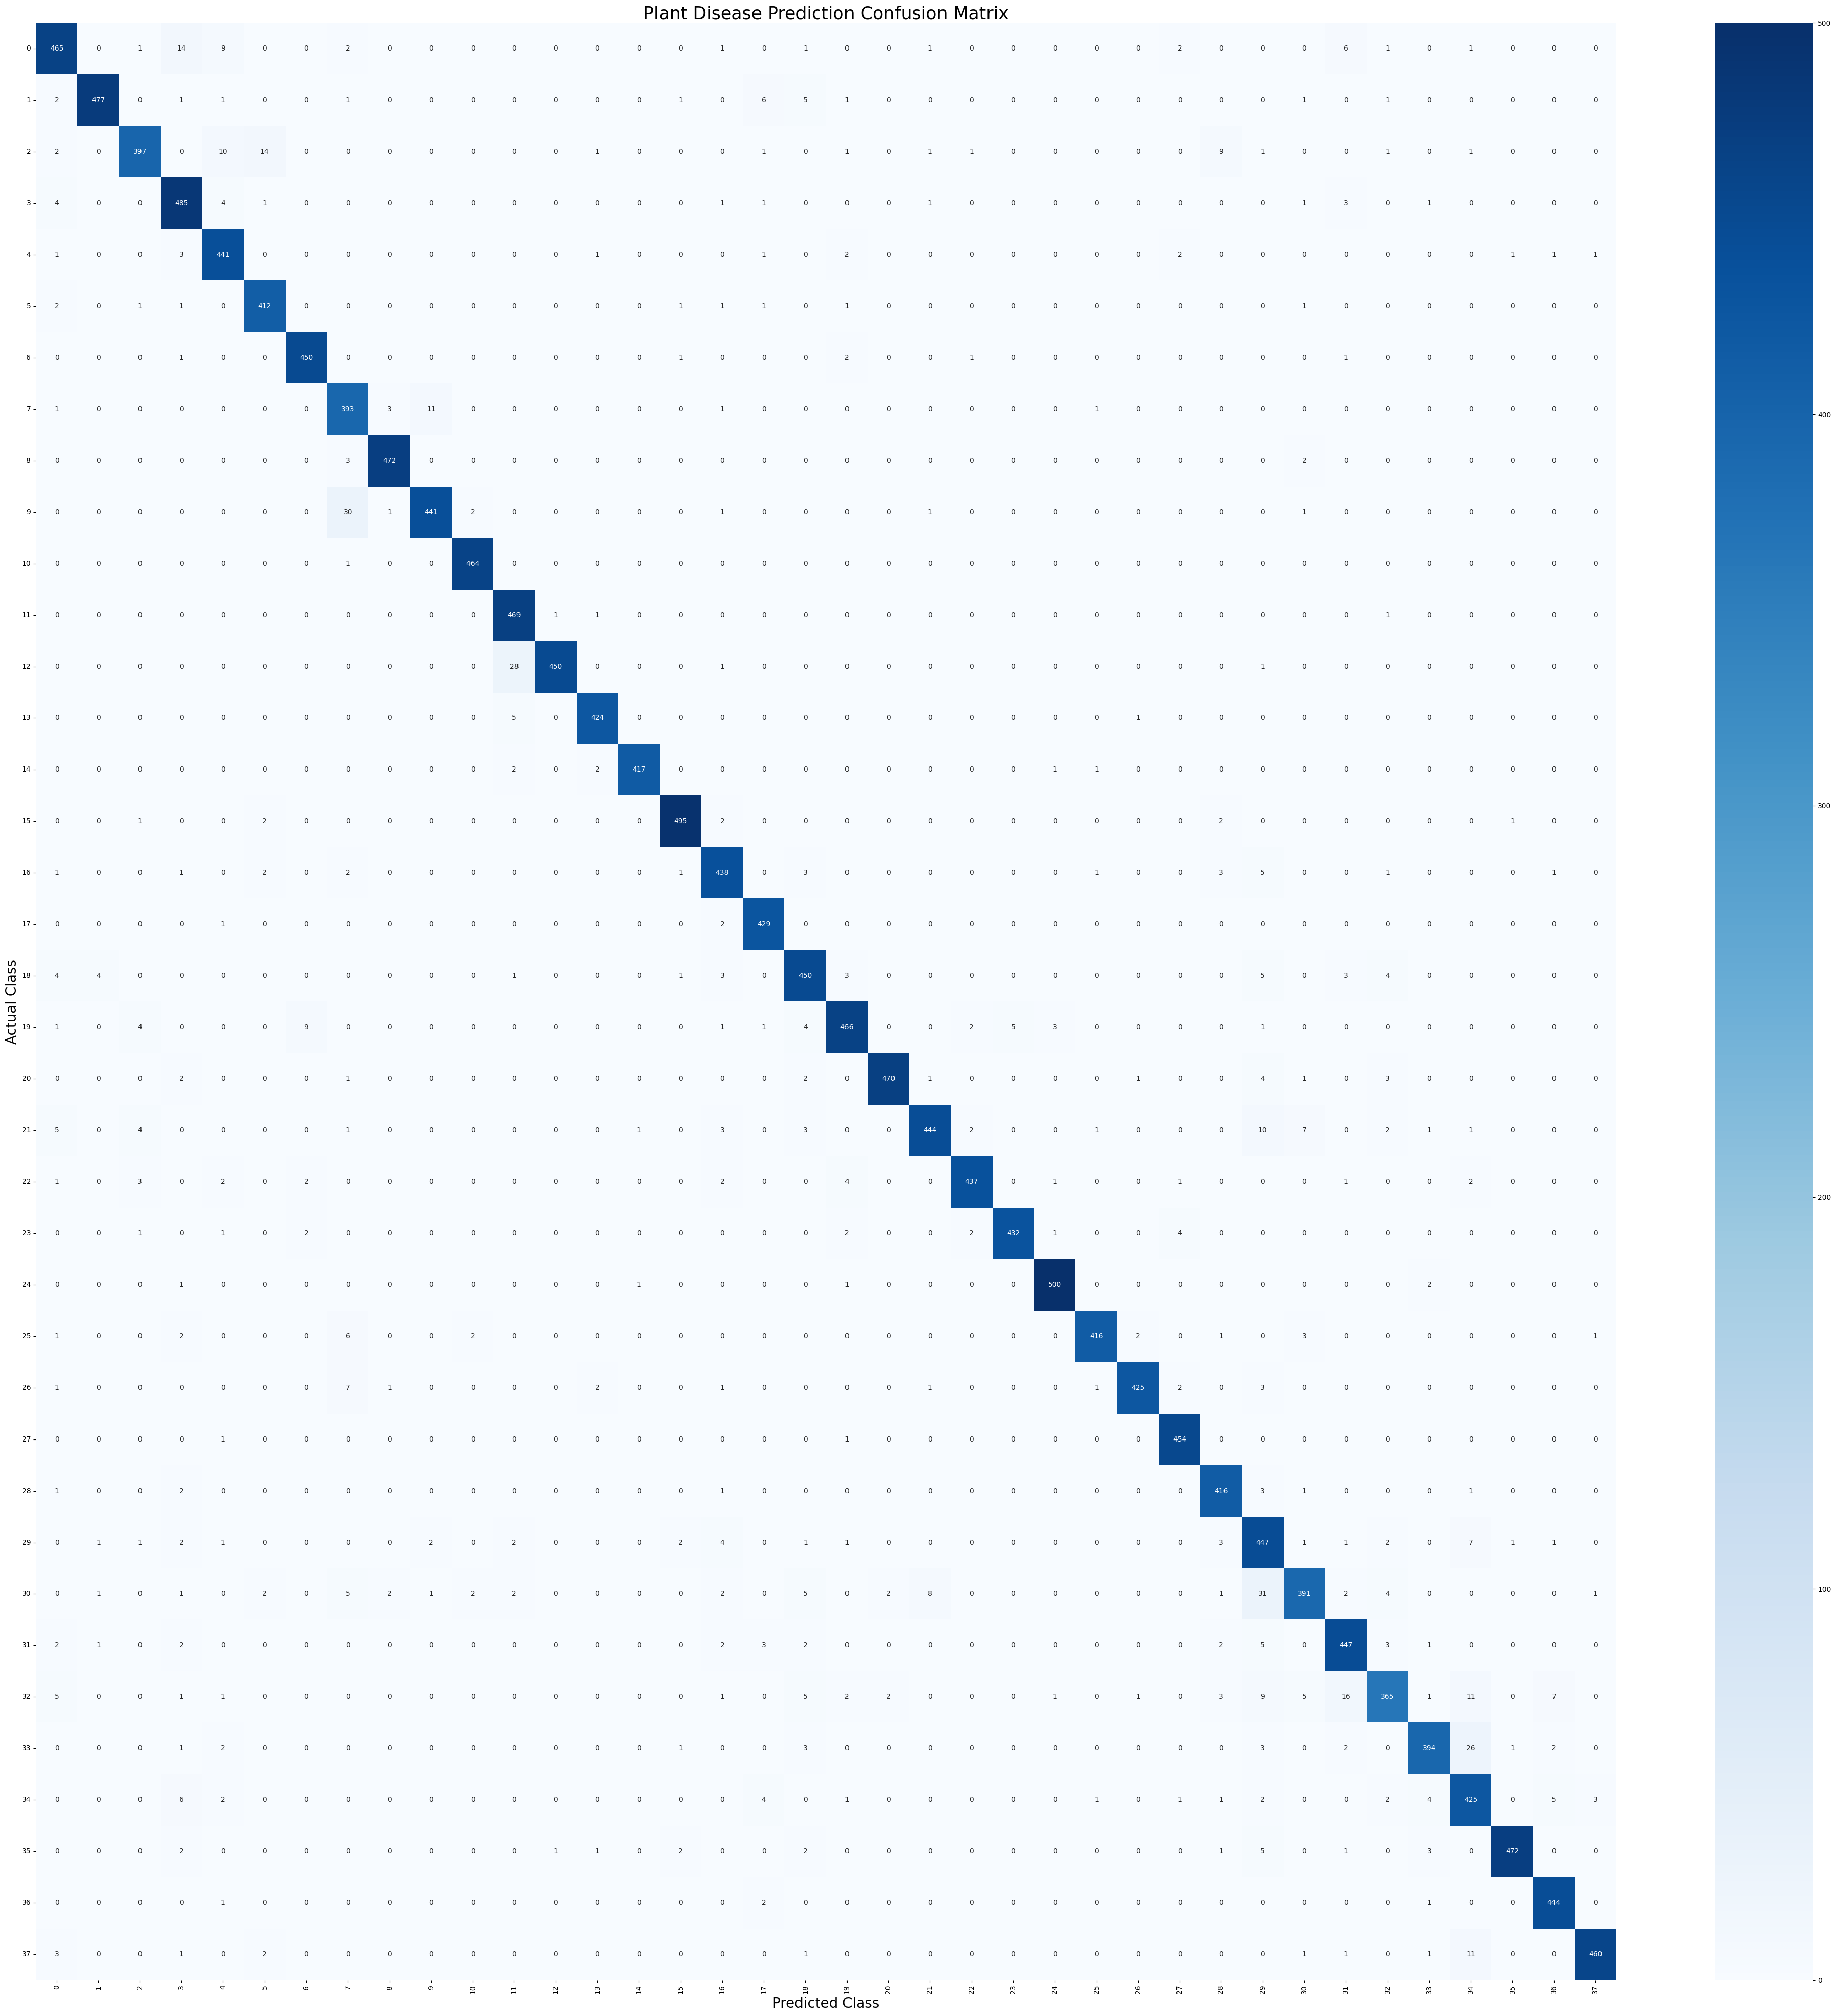

In [137]:
# Confusion Matrix Visualization
cm = confusion_matrix(Y_true, predicted_categories)

plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Actual Class', fontsize=20)
plt.title('Plant Disease Prediction Confusion Matrix', fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()


## Additional Report Visualizations


✓ Training curves saved as 'training_curves.png'


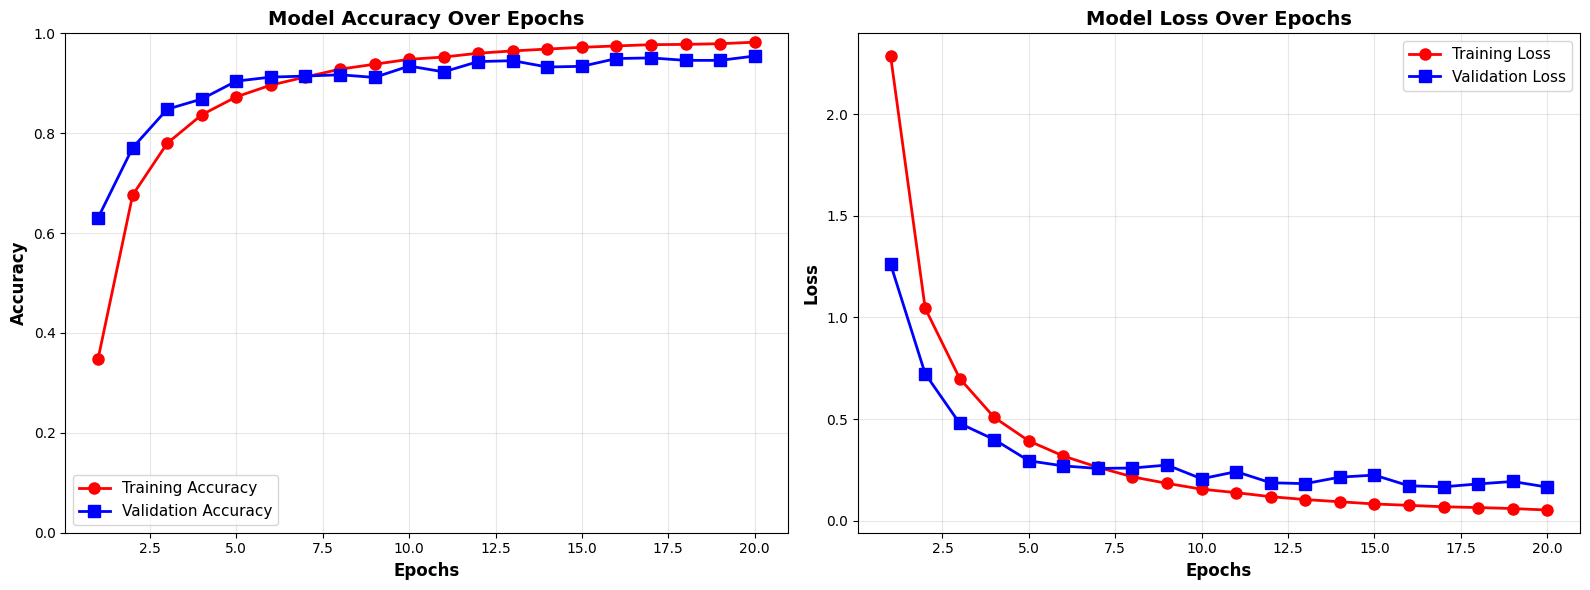

In [138]:
# Training History Visualizations (Already shown in Cell 29, but save high-quality versions)
epochs = range(1, len(training_history.history['accuracy']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1 = axes[0]
ax1.plot(epochs, training_history.history['accuracy'], 
         color='red', marker='o', linewidth=2, markersize=8, label='Training Accuracy')
if 'val_accuracy' in training_history.history:
    ax1.plot(epochs, training_history.history['val_accuracy'], 
             color='blue', marker='s', linewidth=2, markersize=8, label='Validation Accuracy')
ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1])

# Loss plot
ax2 = axes[1]
ax2.plot(epochs, training_history.history['loss'], 
         color='red', marker='o', linewidth=2, markersize=8, label='Training Loss')
if 'val_loss' in training_history.history:
    ax2.plot(epochs, training_history.history['val_loss'], 
             color='blue', marker='s', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Training curves saved as 'training_curves.png'")
plt.show()


In [139]:
# Final Report Summary
print("=" * 80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(f"\n📊 MODEL ARCHITECTURE:")
print(f"   Total Parameters: {cnn.count_params():,}")
print(f"   Layers: {len(cnn.layers)}")
print(f"   Output Classes: {num_classes}")

print(f"\n📈 TRAINING RESULTS:")
print(f"   Epochs Trained: {len(training_history.history['accuracy'])}")
print(f"   Final Training Accuracy: {training_history.history['accuracy'][-1]:.4f} ({training_history.history['accuracy'][-1]*100:.2f}%)")
print(f"   Final Training Loss: {training_history.history['loss'][-1]:.4f}")
print(f"   Best Validation Accuracy: {max(training_history.history['val_accuracy']):.4f} ({max(training_history.history['val_accuracy'])*100:.2f}%)")

print(f"\n🧪 TEST SET EVALUATION:")
print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test Loss: {test_loss:.4f}")

# Calculate per-class accuracy from confusion matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print(f"\n📋 TOP 5 BEST PERFORMING CLASSES:")
top5_indices = class_accuracies.argsort()[-5:][::-1]
for i, idx in enumerate(top5_indices, 1):
    print(f"   {i}. {class_names_list[idx]}: {class_accuracies[idx]:.4f} ({class_accuracies[idx]*100:.2f}%)")

print(f"\n⚠️  TOP 5 WORST PERFORMING CLASSES:")
worst5_indices = class_accuracies.argsort()[:5]
for i, idx in enumerate(worst5_indices, 1):
    print(f"   {i}. {class_names_list[idx]}: {class_accuracies[idx]:.4f} ({class_accuracies[idx]*100:.2f}%)")

print("\n" + "=" * 80)
print("✅ REPORT GENERATION COMPLETE!")
print("=" * 80)
print("\nFiles generated:")
print("  - confusion_matrix.png")
print("  - training_curves.png")
print("  - training_hist.json")


FINAL MODEL PERFORMANCE SUMMARY

📊 MODEL ARCHITECTURE:
   Total Parameters: 7,842,762
   Layers: 20
   Output Classes: 38

📈 TRAINING RESULTS:
   Epochs Trained: 20
   Final Training Accuracy: 0.9823 (98.23%)
   Final Training Loss: 0.0518
   Best Validation Accuracy: 0.9546 (95.46%)

🧪 TEST SET EVALUATION:
   Test Accuracy: 0.9546 (95.46%)
   Test Loss: 0.1648

📋 TOP 5 BEST PERFORMING CLASSES:
   1. Corn_(maize)___healthy: 0.9978 (99.78%)
   2. Strawberry___healthy: 0.9956 (99.56%)
   3. Grape___Black_rot: 0.9936 (99.36%)
   4. Peach___healthy: 0.9931 (99.31%)
   5. Tomato___Tomato_mosaic_virus: 0.9911 (99.11%)

⚠️  TOP 5 WORST PERFORMING CLASSES:
   1. Tomato___Septoria_leaf_spot: 0.8372 (83.72%)
   2. Tomato___Late_blight: 0.8445 (84.45%)
   3. Apple___Cedar_apple_rust: 0.9023 (90.23%)
   4. Tomato___Spider_mites Two-spotted_spider_mite: 0.9057 (90.57%)
   5. Potato___Late_blight: 0.9155 (91.55%)

✅ REPORT GENERATION COMPLETE!

Files generated:
  - confusion_matrix.png
  - training_

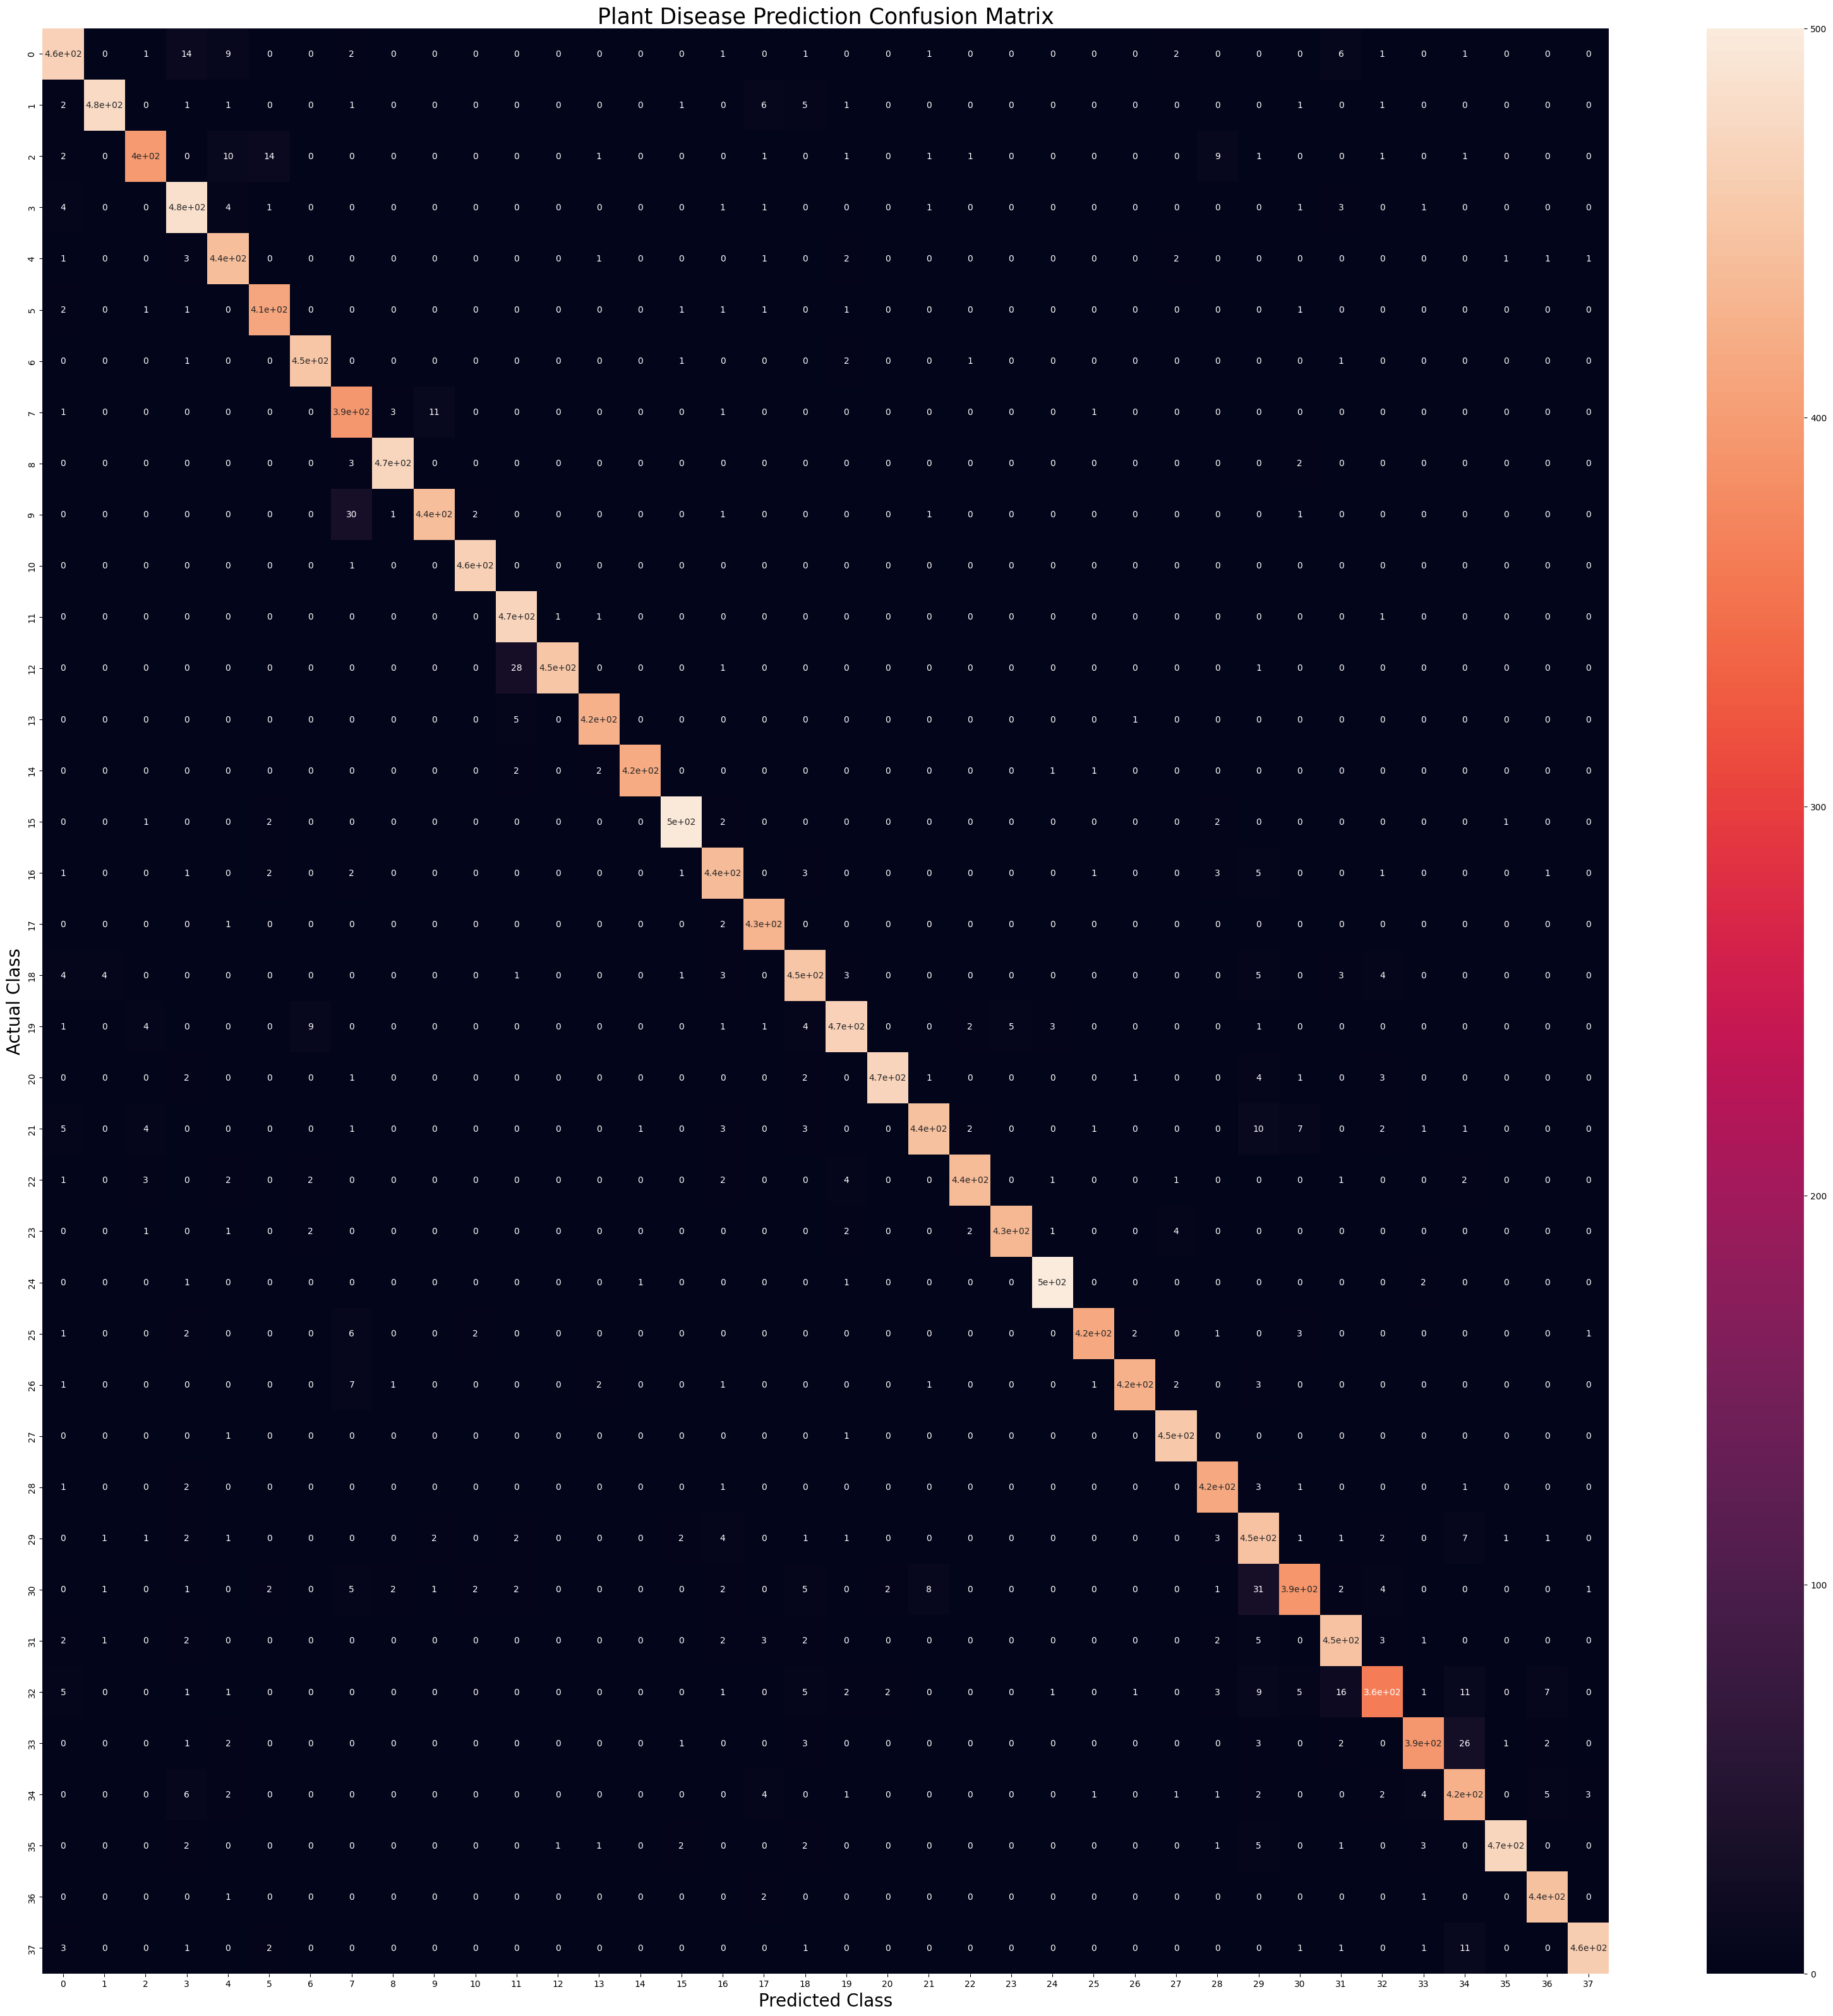

In [140]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()